# Movielens 1M in Colab

In [1]:
!pip install -r ../requirements.txt

  Using cached fuzzymatcher-0.0.6-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.8 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached scikit_learn-1.1.2-cp39-cp39-macosx_12_0_arm64.whl (7.7 MB)
  Using cached Metaphone-0.6-py3-none-any.whl
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


We're setting up a basic recommendation system for Movies!


In [2]:
import duckdb
import pandas as pd
import sqlalchemy
# No need to import duckdb_engine
#  SQLAlchemy will auto-detect the driver needed based on your connection string!

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on ipython-sql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect to in-memory db!
%sql duckdb:///:memory:

In [3]:
%sql SELECT 'Off and flying!' as a_duckdb_column

,a_duckdb_column
0,Off and flying!


# MOVIES FILE DESCRIPTION
(there's a lot more info here: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt)

In [4]:
# How to read the dat files:
# https://programmerah.com/solve-the-utf-8-codec-cant-decode-byte-0xe9-in-position-3114-invalid-continuation-byte-error-23068/
movies = pd.read_table("ml-1m/movies.dat", sep='::', engine='python', header=None, encoding='ISO-8859-1')
movies.columns = ['movie_id', 'title', 'category']
movies

,movie_id,title,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [5]:
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table("ml-1m/ratings.dat", sep='::', engine='python', header=None, encoding='ISO-8859-1')
ratings.columns = columns
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648



USERS FILE DESCRIPTION
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

Read more: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt

In [6]:
columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_table("ml-1m/users.dat", sep='::', engine='python', header=None, encoding='ISO-8859-1')
users.columns = columns
users

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


<AxesSubplot:>

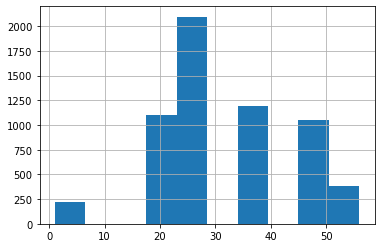

In [7]:
# a lot of user have age of "1"
users.age.hist()

<AxesSubplot:>

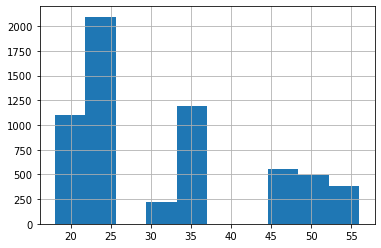

In [8]:
# so we fill it with the average
users.loc[users.age < 10, 'age'] = users.age.mean()
users.age.hist()

# Part 1: Data

In [9]:
# some of these don't have a release date!
metadata = pd.read_csv('ml-1m/movies_metadata.csv')

# clean up the datetime column
# this will replace values like '12' with NaT
metadata['release_date'] = pd.to_datetime(metadata['release_date'], format='%Y-%m-%d', errors='coerce')
metadata['release_year'] = metadata.release_date.dt.year
metadata['release_year'] = metadata.release_year.fillna(0).astype(int)

# sometimes, the overview is null, so we want to distinguish that from... not being in the metadata!
metadata['overview'] = metadata['overview'].fillna('No summary')
metadata = metadata.reset_index()
# metadata

/var/folders/yc/bnql9_hs149_2v2_rk51djbm0000gn/T/ipykernel_27812/123474593.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('ml-1m/movies_metadata.csv')


In [10]:
right_on = ['title', 'release_year']
metadata['appended_title'] = metadata['title'] + ' (' + metadata['release_year'].astype(str) + ')'
metadata[['appended_title']]

,appended_title
0,Toy Story (1995)
1,Jumanji (1995)
2,Grumpier Old Men (1995)
3,Waiting to Exhale (1995)
4,Father of the Bride Part II (1995)
...,...
45461,Subdue (0)
45462,Century of Birthing (2011)
45463,Betrayal (2003)
45464,Satan Triumphant (1917)


In [11]:
d2 = movies.title.str.extract('(.+)\((\d+)\)')
d2.loc[:, 0] = d2.loc[:, 0].str.strip()
d2.loc[:, 1] = d2.loc[:, 1].astype(int)
movies[d2[1].isna()]
movies['_title'] = d2[0]
movies['_year'] = d2[1]
movies

,movie_id,title,category,_title,_year
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,Meet the Parents,2000
3879,3949,Requiem for a Dream (2000),Drama,Requiem for a Dream,2000
3880,3950,Tigerland (2000),Drama,Tigerland,2000
3881,3951,Two Family House (2000),Drama,Two Family House,2000


In [12]:
import fuzzymatcher

In [13]:
# this takes about 15s to work!
matched_results = fuzzymatcher.fuzzy_left_join(movies, metadata,
                                            left_on=['_title', '_year'],
                                            right_on=['title', 'release_year'],
                                            left_id_col='movie_id',
                                            right_id_col='index')
matched_results.columns

Index(['best_match_score', '__id_left', '__id_right', 'movie_id', 'title_left',
       'category', '_title', '_year', 'index', 'adult',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_right', 'video',
       'vote_average', 'vote_count', 'release_year', 'appended_title'],
      dtype='object')

In [14]:
columns_to_pick = [
    'title_left', 'title_right', 'overview', 'release_year', 'vote_count', 'vote_average', 'best_match_score'
]

In [15]:
matched_results[matched_results.overview == 'No summary']

,best_match_score,__id_left,__id_right,movie_id,title_left,category,_title,_year,index,adult,...,runtime,spoken_languages,status,tagline,title_right,video,vote_average,vote_count,release_year,appended_title
257,0.822060,33,32,33,Wings of Courage (1995),Adventure|Romance,Wings of Courage,1995,32,False,...,50.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Wings of Courage,False,6.8,4.0,1996,Wings of Courage (1996)
2506,0.376549,304,300,304,Roommates (1995),Comedy|Drama,Roommates,1995,300,False,...,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Roommates,False,6.4,7.0,1995,Roommates (1995)
5944,1.246231,643,634,643,Peanuts - Die Bank zahlt alles (1996),Comedy,Peanuts - Die Bank zahlt alles,1996,634,False,...,NaN,[],Released,NaN,Peanuts – Die Bank zahlt alles,False,4.0,1.0,1996,Peanuts – Die Bank zahlt alles (1996)
5945,0.634456,644,635,644,Happy Weekend (1996),Comedy,Happy Weekend,1996,635,False,...,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,False,0.0,0.0,1996,Happy Weekend (1996)
6118,1.371955,654,644,654,Und keiner weint mir nach (1996),Drama|Romance,Und keiner weint mir nach,1996,644,False,...,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Und keiner weint mir nach,False,0.0,0.0,1996,Und keiner weint mir nach (1996)
6725,0.149223,693,679,693,Under the Domin Tree (Etz Hadomim Tafus) (1994),Drama,Under the Domin Tree (Etz Hadomim Tafus),1994,679,False,...,0.0,"[{'iso_639_1': 'he', 'name': 'עִבְרִית'}]",Released,NaN,Under The Domim Tree,False,6.5,2.0,1994,Under The Domim Tree (1994)
7647,-0.052830,738,28484,738,"Garcu, Le (1995)",Drama,"Garcu, Le",1995,28484,False,...,103.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Le party,False,7.5,2.0,1990,Le party (1990)
8529,0.091489,771,36817,771,"Vie est belle, La (Life is Rosey) (1987)",Comedy|Drama,"Vie est belle, La (Life is Rosey)",1987,36817,False,...,0.0,[],Released,NaN,C'est la vie,False,0.0,0.0,2001,C'est la vie (2001)
9112,0.719306,814,792,814,"Boy Called Hate, A (1995)",Drama,"Boy Called Hate, A",1995,792,False,...,0.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,A Boy Called Hate,False,6.0,2.0,1996,A Boy Called Hate (1996)
9354,0.345682,826,802,826,Diebinnen (1995),Drama,Diebinnen,1995,802,False,...,NaN,[],Released,NaN,Diebinnen,False,4.0,1.0,1996,Diebinnen (1996)


In [16]:
matched_results[matched_results.appended_title.isna()]

,best_match_score,__id_left,__id_right,movie_id,title_left,category,_title,_year,index,adult,...,runtime,spoken_languages,status,tagline,title_right,video,vote_average,vote_count,release_year,appended_title


## Evaluation of matching results

Matching is very important, bc the data determines the quality of the ML result! For us, the most important thing is to have no _false positive_ match. That is, we want to be very strict about what we match (ie, the year & title match exactly), so that it doesn't end up recommending a movie, and we're like, "Why?!?!" and discover that the overview was actually from another movie!

**Overall, *fuzzy matching* seems like a good idea, bc it's pretty explainable!** If we sort by `best_match_score`, we can see that everything above 0.2 is basically good, but once we hit the bottom 200 results or so (ie, the hardest 5% to match), the match quality is iffy. We can probably focus our manual efforts into writing a routine to do more exact matching here...

So, the good thing is that it matches things in parentheses (like Cannibal Ferox), and things otuside.

But overall, the matches are quite good, considering the work we put in :) let's browse some results

In [17]:
K = 200
matched_results.sort_values('best_match_score')[columns_to_pick][K:K+10]

,title_left,title_right,overview,release_year,vote_count,vote_average,best_match_score
33458,"Goodbye, 20th Century (Zbogum na dvadesetiot v...","Goodbye, 20th Century","In the year 2019, after global destruction and...",1998,2.0,7.5,0.200706
38205,Horror Hotel (a.k.a. The City of the Dead) (1960),The City of the Dead,A young coed (Nan Barlow) uses her winter vaca...,1960,34.0,6.5,0.200833
2754,To Live (Huozhe) (1994),To Live,Fugui and Jiazhen endure tumultuous events in ...,1994,62.0,7.7,0.201226
19407,Welcome to Woop-Woop (1997),Welcome to Sarajevo,Follow a group of international journalists in...,1997,22.0,6.5,0.202793
493,"Postino, Il (The Postman) (1994)",The Postman,Simple Italian postman learns to love poetry w...,1994,181.0,7.6,0.205802
27791,Black Mask (Hak hap) (1996),Black Mask,Chui Chik tries to lead a quiet life as a libr...,1996,55.0,5.8,0.205870
23286,54 (1998),54,"Shane, a Jersey boy with big dreams, crosses t...",1998,138.0,5.5,0.208126
24016,Seven Beauties (Pasqualino Settebellezze) (1976),Seven Beauties,Nominated for four Academy Awards including Be...,1975,10.0,8.8,0.209053
2002,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode III - Revenge of the Sith,"Years after the onset of the Clone Wars, the n...",2005,4200.0,7.1,0.209082
38096,Last Resort (1994),National Lampoon's Last Resort,Sam and Dave are living the boring life until ...,1994,8.0,4.6,0.209180


In [18]:
print(f"{K/len(movies)*100:0.2f}% of movies don't have good matches")

5.15% of movies don't have good matches


In [19]:
import matplotlib.pyplot as plt

<AxesSubplot:>

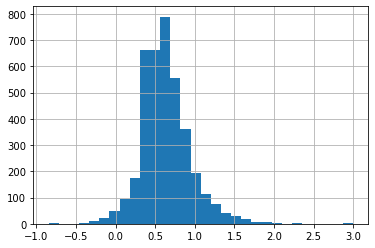

In [20]:
matched_results.best_match_score.hist(bins=30)

# Part II: Modeling

With that out of the way, let's focus on recommendations. The idea is to use the user and item features to build a classifier: given a user and a movie, is the user going to like the movie?


## Feature encoding

User features
- gender - categorical feature
- age - we can bucketize this (ie, 10-20, 20-30), or have it be a dense feature
- occupation - categorical feature
- zip code - categorical feature (although, there's a method to assigning zip codes, so we might think about that)

In [21]:
columns_to_pick = [
    'title_left', 'movie_id', 'category', 'overview', 'release_year'
]
_movies = matched_results[columns_to_pick]
_movies

,title_left,movie_id,category,overview,release_year
0,Toy Story (1995),1,Animation|Children's|Comedy,"Led by Woody, Andy's toys live happily in his ...",1995
1,Jumanji (1995),2,Adventure|Children's|Fantasy,When siblings Judy and Peter discover an encha...,1995
2,Grumpier Old Men (1995),3,Comedy|Romance,A family wedding reignites the ancient feud be...,1995
3,Waiting to Exhale (1995),4,Comedy|Drama,"Cheated on, mistreated and stepped on, the wom...",1995
4,Father of the Bride Part II (1995),5,Comedy,Just when George Banks has recovered from his ...,1995
...,...,...,...,...,...
44452,Meet the Parents (2000),3948,Comedy,"Greg Focker is ready to marry his girlfriend, ...",2000
44453,Requiem for a Dream (2000),3949,Drama,The hopes and dreams of four ambitious people ...,2000
44454,Tigerland (2000),3950,Drama,A group of recruits go through Advanced Infant...,2000
44455,Two Family House (2000),3951,Drama,Buddy Visalo (Michael Rispoli) is a factory wo...,2000


In [22]:
%%sql bigtable <<
select 
rating,
timestamp,
ratings.movie_id as m_id,
title_left as m_title,
category as m_categories,
overview as m_description,
release_year as m_year,
ratings.user_id as u_id,
gender as u_gender,
age as u_age,
occupation as u_occupation,
zip_code as u_zipcode

from ratings
left join _movies on ratings.movie_id = _movies.movie_id
left join users on ratings.user_id = users.user_id

Returning data to local variable bigtable


In [23]:
bigtable['u_zipcode'] = bigtable.u_zipcode.str.split('-').str[0].astype(int)

In [24]:
from sklearn import preprocessing

def compact(df, column):
    le = preprocessing.LabelEncoder()
    le.fit(df[column])
    
    df[column] = le.transform(df[column])
    return df, le

new, le = compact(bigtable, 'u_gender')
print(le.classes_)
print(new.u_gender[:5])

['F' 'M']
0    0
1    0
2    0
3    0
4    0
Name: u_gender, dtype: int64


In [25]:
def multihot(df, column):
    """Splits a column into many columns!
    """
    TEMP = column+'temp'

    df[TEMP] = bigtable[column].str.split('|')
    le = preprocessing.MultiLabelBinarizer()
    le.fit(df[TEMP])
    category_names = ['m_category_%s' % c for c in le.classes_]
    
    # add new columns to the dataframe
    one_hot_array = le.fit_transform(df[TEMP])

    # make a new df
    one_hot_ids = pd.DataFrame(one_hot_array, columns=category_names)

    # Concat with original `Label` column
    return pd.concat([df.drop(TEMP, axis=1), one_hot_ids], axis=1 ), le
    return df, le

## Creating our dataset

In [26]:
import torch
from torch.utils.data import DataLoader

categorical_features = [
    'u_zipcode',
    'u_gender',
    'u_occupation',
    'u_id',
    'm_id'
]

# We may augment features later (time of day!)
continuous_features = [
    'u_age',
    'timestamp',
    'u_zipcode'
]

text_features = [
    'm_title',
    'm_description'
]

class MovieLens1MDataset(torch.utils.data.Dataset):
    """
    MovieLens 1M Dataset
    """

    def __init__(self, bigtable):
        
        # categorical features
        self.encoders = {}
        for f in categorical_features:
            bigtable, encoder = compact(bigtable, f)
            self.encoders[f] = encoder
        
        # Turn Comedy|Drama -> (1,..., 1)
        bigtable, m_category_encoder = multihot(bigtable, 'm_categories')
        self.encoders['m_categories'] = m_category_encoder
        
        # finally, fill in our features
        self.ratings = bigtable['rating']
        self.features = bigtable.drop('rating', axis=1)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, index):
        label = self.ratings.iloc[index]
        features = self.features.iloc[index].to_dict()
        return features, label

    
# let's ignore splits for now :)
data = bigtable
train_dataset = MovieLens1MDataset(data)
test_dataset = MovieLens1MDataset(data)

print(f"We have {len(train_dataset)} data!")

/Users/aii/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We have 1000209 data!


In [27]:
train_dataset.encoders

{'u_zipcode': LabelEncoder(),
 'u_gender': LabelEncoder(),
 'u_occupation': LabelEncoder(),
 'u_id': LabelEncoder(),
 'm_id': LabelEncoder(),
 'm_categories': MultiLabelBinarizer()}

In [28]:
def get_cardinality(feature):
    return len(train_dataset.encoders[feature].classes_)

get_cardinality('u_occupation')

21

In [29]:
from pprint import pprint
torch.manual_seed(0)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
pprint(train_features)
pprint(train_labels)

{'m_categories': ['Comedy|Drama', 'Drama'],
 'm_category_Action': tensor([0, 0]),
 'm_category_Adventure': tensor([0, 0]),
 'm_category_Animation': tensor([0, 0]),
 "m_category_Children's": tensor([0, 0]),
 'm_category_Comedy': tensor([1, 0]),
 'm_category_Crime': tensor([0, 0]),
 'm_category_Documentary': tensor([0, 0]),
 'm_category_Drama': tensor([1, 1]),
 'm_category_Fantasy': tensor([0, 0]),
 'm_category_Film-Noir': tensor([0, 0]),
 'm_category_Horror': tensor([0, 0]),
 'm_category_Musical': tensor([0, 0]),
 'm_category_Mystery': tensor([0, 0]),
 'm_category_Romance': tensor([0, 0]),
 'm_category_Sci-Fi': tensor([0, 0]),
 'm_category_Thriller': tensor([0, 0]),
 'm_category_War': tensor([0, 0]),
 'm_category_Western': tensor([0, 0]),
 'm_description': ['An unattractive 7th grader struggles to cope with suburban '
                   'life as the middle child with un-attentive parents and '
                   'bullies at school.',
                   'In Lille, two penniless young wom

That's pretty good. Finally, we want to extract the text features using Bert

## Tokenizing text features

In [32]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERT_MODEL = BertModel.from_pretrained(
    'bert-base-uncased', output_hidden_states = True, # Whether the model returns all hidden-states.
)
BERT_MODEL.eval()

def get_text_embedding(text):
    """Returns a 768-dim embedding for text, which is the mean of the last 2 BERT hidden states
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = BERT_MODEL(**inputs)
        hidden_states = outputs[2]
        
        last_2_layer_hidden_states = torch.mean(torch.stack(hidden_states[-2:]), axis=0)
        sentence_embedding = torch.mean(last_2_layer_hidden_states, axis=1)
    
    return sentence_embedding

get_text_embedding(["i'm a donkey", "i'm a donkey"]).shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([2, 768])

## Building the model

In [33]:
from torch import nn

class TransformerRecModel(nn.Module):
    """
    Transformer + dense!
    """
    def __init__(self, features):
        super(TransformerRecModel, self).__init__()
        
        self.features = features

        # first, we store all the embeddings
        self.embeddings = nn.ModuleDict(
            [[feature['_'], self.make_embedding(feature)] for feature in features if feature['type'] == 'emb']
        )

        # then, we have our encoder layer
        # d_model is the number of expected features (concatenated inputs)
        input_size = sum(feature['embedding_dim'] for feature in features)
        output_size = input_size
        text_embedding_size = 768
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=8)
        
        # finally, we have an MLP
        self.mlp = nn.Sequential(
            nn.Linear(output_size + 2 * text_embedding_size, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def make_embedding(self, feature):
        return torch.nn.Embedding(feature['n_tokens'], feature['embedding_dim'])

    def forward(self, features):
        embeddings = [self.embeddings[k](features.get(k)) for k in self.embeddings]
        x = torch.concat(embeddings, axis=1)
        x = self.encoder_layer(x)
        
        with torch.no_grad():
            title_embedding = get_text_embedding(features['m_title'])
            desc_embedding = get_text_embedding(features['m_description'])
        
        x = torch.concat([x, title_embedding, desc_embedding], axis=1)
        x = self.mlp(x)
        return x


To set up our model, we feed in a bunch of features. The idea is, for each feature, automaticall

In [34]:
def build_features():
    """Returns a feature metadata list, which the model takes
    """
    features = []
    for f in categorical_features:
        features.append({
            '_': f,
            'type': 'emb',
            'n_tokens': get_cardinality(f),
            'embedding_dim': 16
        })
    return features

print("Running single pass...")
features = build_features()

# Single pass!
t = TransformerRecModel(features)
train_features, train_labels = next(iter(train_dataloader))
t(train_features)

Running single pass...


tensor([[0.1263],
        [0.1049]], grad_fn=<AddmmBackward0>)

In [35]:
t

TransformerRecModel(
  (embeddings): ModuleDict(
    (u_zipcode): Embedding(3403, 16)
    (u_gender): Embedding(2, 16)
    (u_occupation): Embedding(21, 16)
    (u_id): Embedding(6040, 16)
    (m_id): Embedding(3706, 16)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=True)
    )
    (linear1): Linear(in_features=80, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=80, bias=True)
    (norm1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=1616, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4):

In [36]:
def show_params(name, network):
    c = 0
    print(f"----{name}----")
    for parameter in network.parameters():
        if len(parameter.shape) > 1:
            c += parameter.shape[0] * parameter.shape[1]
            # print(parameter.shape, parameter.shape[0] * parameter.shape[1])
        else:
            c += parameter.shape[0]
    print(f"{c} total parameters")
    
show_params("Embedding layer", t.embeddings)
show_params("Transformer layer", t.encoder_layer)
show_params("Dense tower", t.mlp)
show_params("TOTAL", t)

----Embedding layer----
210752 total parameters
----Transformer layer----
356048 total parameters
----Dense tower----
163741 total parameters
----TOTAL----
730541 total parameters


Oof, we went really fast! Lots to do



# Part III: Metrics & Training

The most important thing to do (besides cleaning data) is setting up the basic evaluation/deploy loop! We're going to define a few metrics, calculate them, and build a simple training loop to improve our score

In [37]:

import random
import numpy as np
torch.use_deterministic_algorithms(True)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(10)
test_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_features, labels = next(iter(test_dataloader))
predictions = t(test_features).flatten()

loss = nn.MSELoss()

def mae(a,b):
    return torch.mean(torch.abs(a-b))

def mse(a,b):
    """Basically does this"""
    return torch.mean((a-b)**2)

print(predictions)
print(labels)
print(loss(predictions, labels), mse(predictions, labels))
print("MAE", mae(predictions, labels).item())

tensor([0.1202, 0.0966, 0.0806, 0.1055, 0.0556, 0.1324, 0.1133, 0.0766],
       grad_fn=<ReshapeAliasBackward0>)
tensor([5, 4, 3, 3, 5, 3, 5, 3])
tensor(15.1309, grad_fn=<MseLossBackward0>) tensor(15.1309, grad_fn=<MeanBackward0>)
MAE 3.7774131298065186


Finally, training loop!

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
feature_meta = build_features()
model = TransformerRecModel(feature_meta)

mse_loss = nn.MSELoss()

learning_rate = 1e-3
weight_decay = 1e-6
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def log_metrics(key, metrics):
    print(key, metrics)

set_seed(10)
for i in range(50):
    features, labels = next(iter(train_dataloader))
    preds = model(features).flatten()
    labels = labels.float()
    
    # compute metrics
    if i % 5 == 0:
        metrics = {
            'mae': mae(preds, labels).item()
        }
        log_metrics(f"Step {i}", metrics)

    # compute loss
    loss = mse_loss(preds, labels)
    loss.backward()
    
    # gradient descent
    optim.step()
    

Step 0 {'mae': 4.0672383308410645}
Step 10 {'mae': 0.5805878639221191}
Step 20 {'mae': 3.364004135131836}
Step 30 {'mae': 1.9065085649490356}
Step 40 {'mae': 3.7303292751312256}
Step 50 {'mae': 3.540024757385254}
Step 60 {'mae': 3.4347925186157227}
Step 70 {'mae': 2.608381986618042}
Step 80 {'mae': 2.3358845710754395}
Step 90 {'mae': 0.8189630508422852}


There's a lot more that can be done here, for example:
- Training - better training loop. utilize GPU/TPU to fit better. fit the model. overfit, possibly as a sanity check.
- Validation - Hold out a portion for test!
- Monitoring - Sanity check your model! In case there are some bugs when implementing

And overall, this whole notebook is not great for productionization! 
- Dockerfile is OK, if we want to do that.
- Will probably split it out into actual code!

# Part IV: Production

OK, let's say we've trained the model, evaluated it on our test set, and it works just right. How to serve it?

We built our model on the idea of it being served like this:
1. OFFLINE - Precompute all the movie embeddings
2. ONLINE - Get the user embeddings, compute them, and use it to find the closest matches in terms of movie embeddings


**Recommending movies**

1. To get the movies for the user, we'd need to use this model to score *every single movie*, and rank the movies by their score. This might be feasible if we know all the users ahead of time! E.g. Amazon's most valued customers.
2. Alternatively, we can use heuristics to pick a few movies (say, 10), and regard this model as our "ranker" model, which will output a very accurate score of how many stars the user will give the movie. Here's an example of this second case:

In [40]:
set_seed(10)

# imagine our serving interface is like this
def get_predictions(_user_features):
    """Returns the best movies for a given user
    
    somewhere upstream, we've pulled out all the user information into this features, validated them, etc
    """
    # pretend that we picked 8 potential movies, and joined them with the _user_features, to generate 
    # the model inputs
    features, _ = next(iter(train_dataloader))
    predictions = model(features)
    
    # let's see what the movies were
    movies = features['m_title']
    print(movies)

    return predictions

# our model scores a (movie, user) pair, so these are ten different (movie, user) pair scores
preds = get_predictions("imagine we actually get the user features")
preds

['Galaxy Quest (1999)', 'Them! (1954)', 'Dogma (1999)', 'What Dreams May Come (1998)', 'Duck Soup (1933)', 'Out of Sight (1998)', 'Tron (1982)', 'Outbreak (1995)']


tensor([[5.9917],
        [5.6730],
        [5.2652],
        [5.2745],
        [5.2292],
        [5.4714],
        [5.4437],
        [5.5967]], grad_fn=<AddmmBackward0>)